In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

midtransit_f = 2455422.710
midtransit_e = 2454983.404
period_f_init = 267.291
period_e_init = 122.3874

# phase = 360 * (midtransit_f - midtransit_e)/period_e % 1

mass_e_init = 4.45356410231 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)
mass_f_init = 3.26277846782 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)

em, eu, el = 4.45356410231 * float(M_earth/M_sun), 3.18331500837 * float(M_earth/M_sun), 1.68965648037 * float(M_earth/M_sun)
fm, fu, fl = 3.26277846782 * float(M_earth/M_sun), 2.10481702794 * float(M_earth/M_sun), 1.15211292891 * float(M_earth/M_sun)

mass_e_init_err = np.max([eu, el])
mass_f_init_err = np.max([fu, fl])


In [11]:
random_samples = np.load("k62_random_samples.npy")

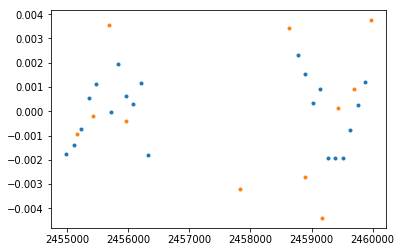

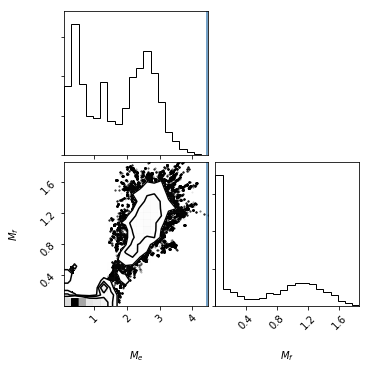

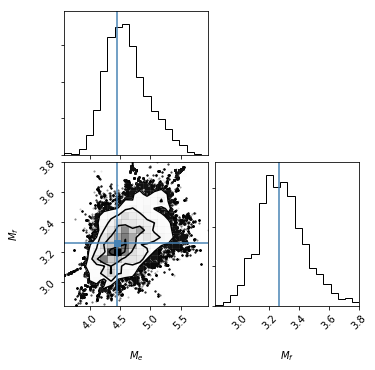

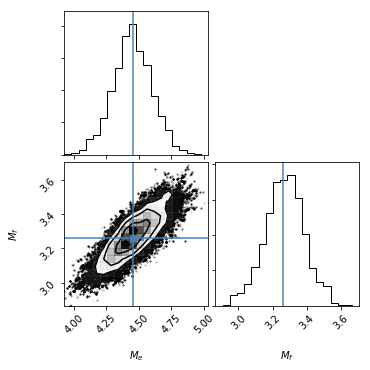

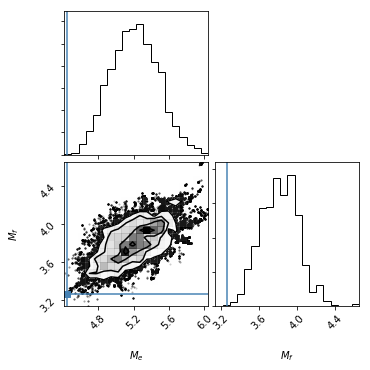

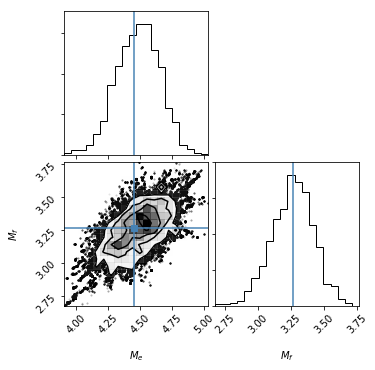

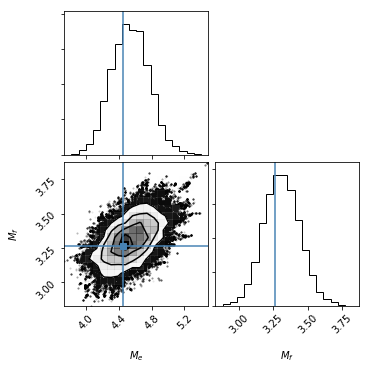

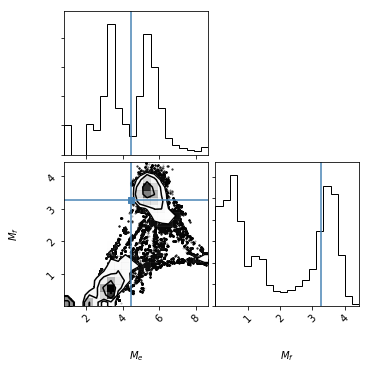

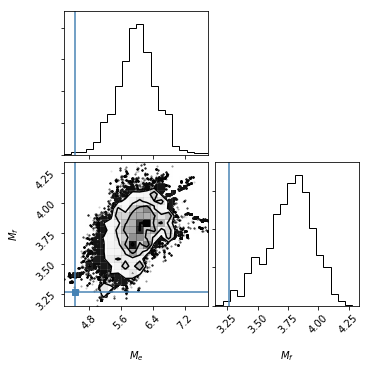

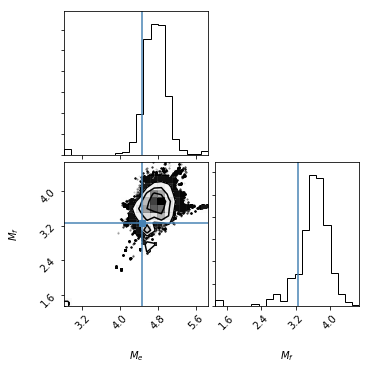

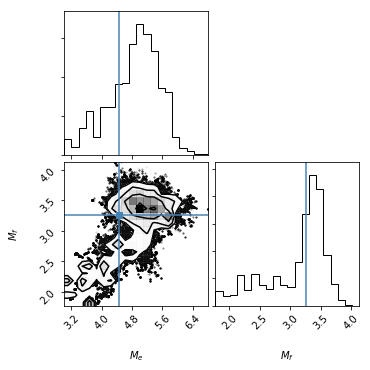

In [46]:
import emcee
from corner import corner

from astropy.constants import G, M_sun

for it, sample in zip(range(0, len(random_samples)), random_samples[:]): 

    observed_timing = np.loadtxt("../libra/data/ttvs/timing_k62_Kep_HST.txt", delimiter=',')
    timing_e = observed_timing[observed_timing[:, 0] == 1][:, -3:]
    timing_f = observed_timing[observed_timing[:, 0] == 2][:, -3:]

    all_epochs_e = np.load('k62_epochs_e.npy')
    all_epochs_f = np.load('k62_epochs_f.npy')

    timing_e[:, 1] += 2450000
    timing_f[:, 1] += 2450000

    epochs_e, times_e, errs_e = timing_e.T
    epochs_f, times_f, errs_f = timing_f.T
    
    mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = sample

    e = Planet(mass=mass_e_init, period=period_e, eccentricity=ecc_e, inclination=89.98, 
               longnode=90, argument=w_e, mean_anomaly=lam_e)
    f = Planet(mass=mass_f_init, period=period_f, eccentricity=ecc_f, inclination=89.90, 
               longnode=90, argument=w_f, mean_anomaly=lam_f)
    result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, dt=period_e/50, total=times_e.min()+5000)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    ignore_condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    indices_e = (planet_ind == 0) & np.in1d(epoch, all_epochs_e)
    indices_f = (planet_ind == 1) & np.in1d(epoch, all_epochs_f)
    all_epoch_e = epoch[indices_e]
    all_epoch_f = epoch[indices_f]
    all_e = times[indices_e]
    all_f = times[indices_f]

    linear_ephem_e = np.polyval(np.polyfit(epoch_e, all_e, 1), epoch_e)
    linear_ephem_f = np.polyval(np.polyfit(epoch_f, all_f, 1), epoch_f)
    
    plt.plot(all_e, all_e-linear_ephem_e, '.')
    plt.plot(all_f, all_f-linear_ephem_f, '.')
    plt.show()

#     #all_e = np.load('all_transits_e.npy')
    all_err_e = (25*u.s).to(u.day).value * np.ones_like(all_e)
#     #all_f = np.load('all_transits_f.npy')
    all_err_f = (41*u.s).to(u.day).value * np.ones_like(all_f)
# 
#     all_epoch_e = np.round((all_e - timing_e[:, 1].min()) / period_e_init)
#     all_epoch_f = np.round((all_f - timing_f[:, 1].min()) / period_f_init) #+ 1

#     timing_e = np.vstack([timing_e, np.array([all_epoch_e, all_e, all_err_e]).T])
#     timing_f = np.vstack([timing_f, np.array([all_epoch_f, all_f, all_err_f]).T])
    
    
#     linear_ephem_e = np.polyval(np.polyfit(epochs_e, times_e, 1), epochs_e)
#     linear_ephem_f = np.polyval(np.polyfit(epochs_f, times_f, 1), epochs_f)
#     plt.errorbar(times_e, 24*60*(times_e - linear_ephem_e), 24*60*errs_e)
#     plt.errorbar(times_f, 24*60*(times_f - linear_ephem_f), 24*60*errs_f)
#     plt.xlabel('JD')
#     plt.ylabel('O-C [min]')
#     plt.show() 

#     epochs_e, times_e, errs_e = timing_e.T
#     epochs_f, times_f, errs_f = timing_f.T

#     linear_ephem_e = np.polyval(np.polyfit(epochs_e, times_e, 1), epochs_e)
#     linear_ephem_f = np.polyval(np.polyfit(epochs_f, times_f, 1), epochs_f)

#     print(times_e.shape, epochs_e.shape, errs_e.shape)
#     plt.plot(times_e, times_e-linear_ephem_e, '.')
#     plt.plot(times_f, times_f-linear_ephem_f, '.')
#     plt.show()
    
    ## Fit
    M_starM_sun = 0.69
    M_star = M_starM_sun * M_sun
    a_e = ( ( (G * M_star)/(4 * np.pi**2) * (period_e_init*u.day)**2 )**(1/3) ).decompose()
    a_f = ( ( (G * M_star)/(4 * np.pi**2) * (period_f_init*u.day)**2 )**(1/3) ).decompose()

    def lnprob(p):
        mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = p

        if (mass_e < 0 or mass_f < 0 or mass_e > 1e-3 or mass_f > 1e-3 or 
            ecc_e < 0 or ecc_e > 0.3 or ecc_f < 0 or ecc_f > 0.3):
            return -np.inf

        # Hill stability criterion from Gladman 1993 Eqn. 21
        gamma1 = np.sqrt(1 - ecc_e**2)
        gamma2 = np.sqrt(1 - ecc_f**2)
        mu1 = mass_e * M_starM_sun
        mu2 = mass_f * M_starM_sun
        alpha = mu1 + mu2
        Delta = (a_f - a_e)/a_e
        delta = np.sqrt(1 + Delta)

        if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
            1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
            return -np.inf

        # Run TTVFast
        e = Planet(mass=mass_e, period=period_e, eccentricity=ecc_e, inclination=89.98, 
                   longnode=90, argument=w_e, mean_anomaly=lam_e)
        f = Planet(mass=mass_f, period=period_f, eccentricity=ecc_f, inclination=89.90, 
                   longnode=90, argument=w_f, mean_anomaly=lam_f)
        result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, 
                         dt=period_e/30, total=times_e.min()+6000)
        planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
        ignore_condition = (times != -2)
        planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]

        # Parse results for planets e and f
        indices_e = (planet_ind == 0) & np.in1d(epoch, all_epoch_e)
        indices_f = (planet_ind == 1) & np.in1d(epoch, all_epoch_f)#+1)
        epoch_e = epoch[indices_e]
        epoch_f = epoch[indices_f]
        model_times_e = times[indices_e]
        model_times_f = times[indices_f]

        # Compute chi^2 for transit times of e and f
        logchi2_e = -0.5 * np.sum( (model_times_e - all_e)**2 / all_err_e**2 )
        logchi2_f = -0.5 * np.sum( (model_times_f - all_f)**2 / all_err_f**2 )

        # Add log prior for planet mass from Gaia + forecaster
        lnprior = (-0.5 * (mass_e - mass_e_init)**2 / mass_e_init_err**2
                   -0.5 * (mass_f - mass_f_init)**2 / mass_f_init_err**2)
        return logchi2_e + logchi2_f + lnprior

    ndim, nwalkers = 10, 100
    init_masses = np.load('maxlnprob_ttv_params.npy') 
    p0 = [init_masses + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
    p1 = sampler.run_mcmc(p0, 5000)[0];
    sampler.reset()
    p2 = sampler.run_mcmc(p1, 5000)[0] # 15 min
    
    
    chains = np.copy(sampler.flatchain)
    chains[:, :2] /= float(M_earth/M_sun)
    
    corner(chains[:, :2], labels="$M_e$,$M_f$".split(','), truths=[mass_e_init / float(M_earth/M_sun), 
                                                               mass_f_init / float(M_earth/M_sun)]);
    plt.savefig('masses/masses_kitchen_sink_{0:02d}.pdf'.format(it), dpi=250, bbox_inches='tight')
    
    del sampler 